In [1]:
import os
import json
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset
from tqdm import tqdm
import spacy

import transformer_lens
from probe_model import LinearProbe, Trainer, TrainerConfig

## Setup

In [2]:
device_name = "cpu"
if torch.cuda.is_available():
    device_name = "cuda" # CUDA for NVIDIA GPU

device = torch.device(device_name)
print(f"Device: {device_name}")

Device: cuda


In [3]:
model_name = "gpt2-small"
model = transformer_lens.HookedTransformer.from_pretrained(model_name)

Loaded pretrained model gpt2-small into HookedTransformer


In [4]:
# Load the spaCy model
spacy_model = spacy.load("en_core_web_sm")

## Generate dataset

### Load text

In [76]:
with open('datasets/brown.dev', 'r') as f:
    raw_sentences = [line.rstrip("\n") for line in f.readlines()]

DATASET_CUTOFF = 2000
raw_sentences = raw_sentences[:DATASET_CUTOFF]
np.random.choice(raw_sentences, 5)

array(["`` I ain't drawin' against you '' , Jess said thickly .",
       "`` Too much fooling around '' , he said .",
       'How could he comprehend her need when he himself was innocent ? ?',
       'Facing the forest now , she who had not dared to enter it before , walked between two trees at random and headed in what she believed was the direction of the pool .',
       "But '' --"], dtype='<U284')

### Generating text sequences with labels (word index)

In [77]:
def map_word_index(text, prepend_bos=False):
    gpt_tokens = model.to_tokens(text, prepend_bos=prepend_bos).squeeze(0)
    gpt_tokens_str = [model.to_single_str_token(int(t)) for t in gpt_tokens]

    doc = spacy_model(str(text))
    word_idxs = [t.text for t in doc if t.is_alpha]

    if not len(word_idxs):
        return torch.Tensor(), []

    i = 0
    cur = 0 # current word index
    sub_idx = 0 # sub index of current word

    result = []
    while i < len(gpt_tokens_str):
        t = gpt_tokens_str[i].strip()
        # skip if token is just a newline or other whitespace
        if not len(t):
            result.append((t, i, -1))
            i += 1
            continue

        cur_word = word_idxs[cur]
        # if token is part of current word, update sub_idx, continue to next token
        if cur_word.find(t, sub_idx) != -1:
            result.append((t, i, cur))
            sub_idx += len(t)
            i += 1
        else:
            # if token not in cur_word, check next word
            if cur+1 < len(word_idxs) and t in word_idxs[cur+1]:
                cur += 1
                sub_idx = 0
            # if not in cur_word or next word, give up and continue
            else:
                result.append((t, i, -1))
                i += 1 

    return gpt_tokens, result

In [ ]:
# check that map_word_index function is working correctly
# for s in tqdm(raw_sentences):
#     tokens, info = map_word_index(s)
#     assert len(tokens) == len(info)

In [89]:
SEQ_LEN = 200

def generate_seq():
    tokens = model.to_tokens("\n", prepend_bos=True).squeeze(0)
    info = [("\n", 0, -1)]

    while len(tokens) < SEQ_LEN:
        next_t, next_info = map_word_index(np.random.choice(raw_sentences))
        if len(next_t):
            tokens = torch.cat((tokens, next_t))
            info.extend(next_info)

    labels = np.array(list(map(lambda x: x[2], info)))
    return tokens, labels

tokens, labels = generate_seq()
np.unique(labels, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]),
 array([35, 18, 17, 14, 14, 10, 10, 12, 10,  9,  8,  7,  6,  6,  3,  3,  2,
         3,  2,  2,  2,  2,  2,  1,  1,  1,  1,  1]))

### Generate Embeddings

In [91]:
N_SEQS = 1000
# cutoff initial tokens because model behavior is weird there
PREFIX_CUTOFF = 10

torch.set_grad_enabled(False)

all_resids = []
all_labels = []

for i_batch in tqdm(range(N_SEQS)):
    tokens, labels = generate_seq()

    _, cache = model.run_with_cache(tokens, names_filter=lambda x: x.endswith("resid_post"))
    residuals = cache.stack_activation("resid_post")

    # residuals.shape = (layer, batch, seq_len, model_residual_dimension)
    residuals = residuals[:, 0, PREFIX_CUTOFF+1:, :]
    labels = labels[PREFIX_CUTOFF:]

    assert residuals.shape[1] == labels.shape[0]

    # this mask excludes puncuation and word fragments
    mask = labels != -1

    all_resids.append(residuals.cpu().numpy()[:, mask])
    all_labels.append(labels[mask])



100%|██████████| 1000/1000 [01:49<00:00,  9.12it/s]


In [92]:
x_all_layers = np.concatenate(all_resids, axis=1)
y = np.concatenate(all_labels)

mask = y <= 9
x_all_layers = x_all_layers[:, mask]
y = y[mask]

print(x_all_layers.shape)
print(y.shape)

(12, 104490, 768)
(104490,)


## Training Probes

In [93]:
class ProbingDataset(Dataset):
    def __init__(self, act, y):
        assert len(act) == len(y)
        print(f"dataset: {len(act)} pairs loaded...")
        self.act = act
        self.y = y
        print("y:", np.unique(y, return_counts=True))
        
    def __len__(self, ):
        return len(self.y)
    
    def __getitem__(self, idx):
        return torch.tensor(self.act[idx]), torch.tensor(self.y[idx]).long()

In [94]:
LAYER = 3
x = x_all_layers[LAYER, :, :]

probing_dataset = ProbingDataset(x, y)
train_size = int(0.8 * len(probing_dataset))
test_size = len(probing_dataset) - train_size
probe_train_dataset, probe_test_dataset = torch.utils.data.random_split(probing_dataset, [train_size, test_size])
print(f"split into [test/train], [{test_size}/{train_size}]")

dataset: 104490 pairs loaded...
y: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([14233, 12735, 12065, 11498, 10878, 10042,  9304,  8521,  7838,
        7376]))
split into [test/train], [20898/83592]


In [95]:
probe = LinearProbe(device, 768, 10)

EXPERIMENT_NAME = "brown_test_104k"
folder = f"ckpts/{model_name}/{EXPERIMENT_NAME}/layer{LAYER}"
config = TrainerConfig(num_epochs=40, ckpt_path=folder)
trainer = Trainer(device, probe, probe_train_dataset, probe_test_dataset, config)

In [96]:
trainer.train()

Epoch 40; Train Loss: 0.78795; Train Acc: 69.196%; Test Acc: 67.844%: 100%|██████████| 40/40 [00:59<00:00,  1.48s/it]


In [97]:
print(trainer.generate_report())

              precision    recall  f1-score   support

           0     0.9973    0.9949    0.9961      2949
           1     0.9595    0.9556    0.9576      2408
           2     0.8379    0.8455    0.8417      2440
           3     0.6531    0.6871    0.6697      2285
           4     0.5585    0.5997    0.5784      2221
           5     0.5079    0.4816    0.4944      2006
           6     0.4581    0.4004    0.4273      1843
           7     0.4107    0.4628    0.4352      1694
           8     0.4696    0.4483    0.4587      1604
           9     0.5694    0.5325    0.5503      1448

    accuracy                         0.6784     20898
   macro avg     0.6422    0.6408    0.6409     20898
weighted avg     0.6778    0.6784    0.6776     20898



### plotting loss curves

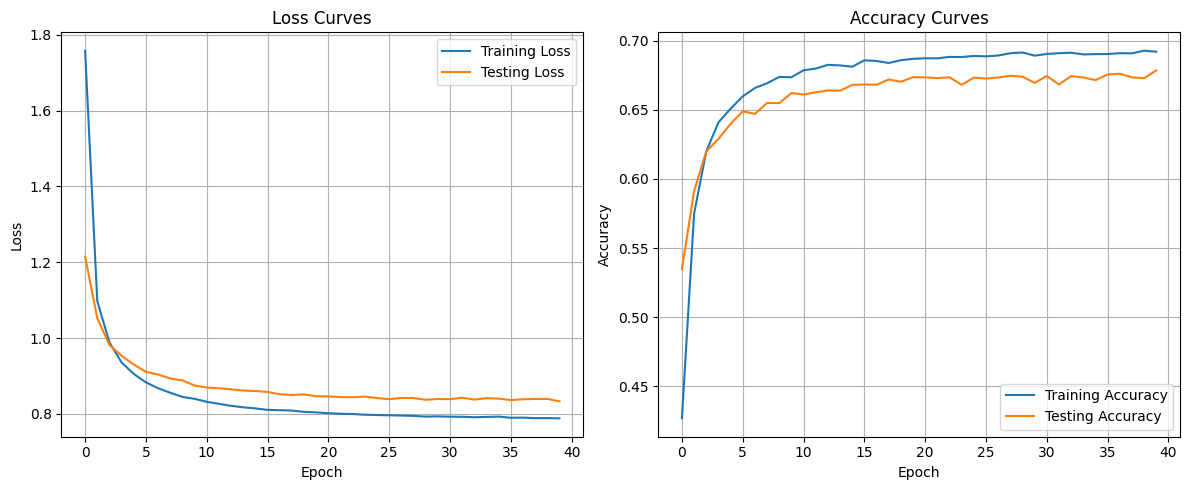

In [98]:
metrics_path = os.path.join(folder, 'metrics.json')

# Load the metrics from the JSON file
with open(metrics_path, 'r') as f:
    metrics = json.load(f)['metrics']

# Extract the loss and accuracy data
train_loss = metrics['train_loss']
test_loss = metrics['test_loss']
train_acc = metrics['train_acc']
test_acc = metrics['test_acc']

# Plot the loss curves
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Testing Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(test_acc, label='Testing Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()